[ 데이터 분포 시각화 및 형태 확인]
- 

[1] 모듈 로딩 및 데이터 준비 <hr>

In [ ]:
## 모듈로딩
import pandas as pd
import numpy as np
from numpy import random
import wquantiles as wq
from scipy.stats import skew, kurtosis      #왜도, 첨도
import matplotlib.pyplot as plt
import koreanize_matplotlib

In [22]:
## --------------------------------------------------------------
## 예제 데이터 만들기
## --------------------------------------------------------------
## 데이터 재현성 설정
np.random.seed(42)

## 표준정규분포(평균0, 표준편차1)에 가까운 예제 데이터 1000개
data_normal = np.random.normal(loc=0, scale=1, size=1000)

## 오른족으로 긴 꼬리를 가진 치우친 데이터 (지수분포)
data_skewed = np.random.exponential(scale=1, size=1000)

## pandas Series로 변환
normalSR = pd.Series(data_normal, name='normal')
skewedSR = pd.Series(data_skewed, name='skewed')

In [23]:
def print_stats(series):
    ## ndarray로 변환
    x = series.values

    ##평균, 표준편차(ddof=1, 불편분산, 표본 데이터이기 때문)
    mean = x.mean()
    std = x.std(ddof=1)
    ## 왜도(skewness) : 비대칭 정도
    sk = skew(x, bias=False)        ## bias=False : 표본 기준 불편추정
      
    ## 첨도(kurtosis) : 뾰족한 정도 -> 이상치 체크
    ku = kurtosis(x, fisher=True, bias=False)
    ## - fisher=True : 정규분포 기준 0이 되도록(초과정도, excess kurtosis)
    ## - fisher=False : 정규분포 기준 3

    print(f"=== {series.name} 데이터 통게 ===")
    print(f" 개수 : {len(x)}")
    print(f" 평균 : {mean:.3f}")
    print(f" 표준편차 : {std:.3f}")
    print(f" 왜도 : {sk:.3f}")
    print(f" 첨도(초과) : {ku:.3f} (정규분포는 0 근처)")
    print()
    

## 데이터별 통계 정보 출력
print_stats(normalSR)
print_stats(skewedSR)

=== normal 데이터 통게 ===
 개수 : 1000
 평균 : 0.019
 표준편차 : 0.979
 왜도 : 0.117
 첨도(초과) : 0.073 (정규분포는 0 근처)

=== skewed 데이터 통게 ===
 개수 : 1000
 평균 : 1.008
 표준편차 : 1.003
 왜도 : 1.984
 첨도(초과) : 5.412 (정규분포는 0 근처)



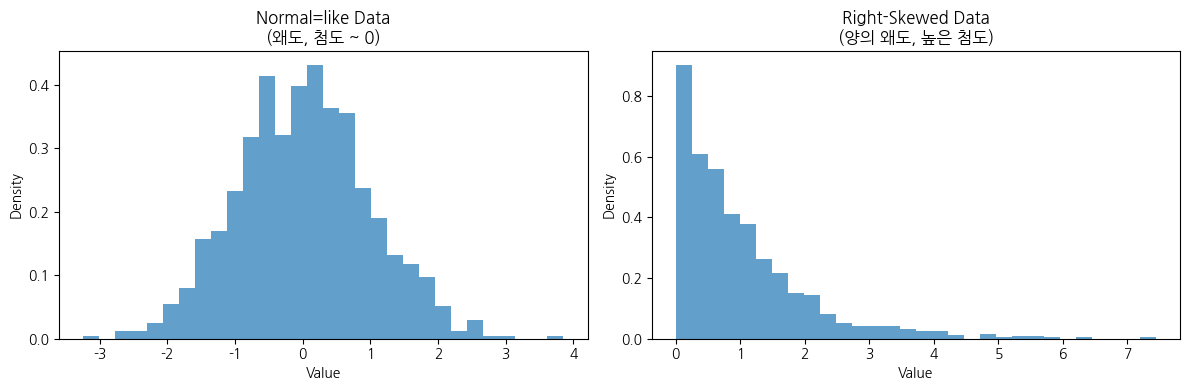

In [40]:
## --------------------------------------------------------------
## 데이터 분포 시각화 - 히스토그램
## --------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

## 정규분포 데이터 히스토그램
axes[0].hist(normalSR, bins=30, density=True, alpha=0.7)
axes[0].set_title('Normal=like Data\n(왜도, 첨도 ~ 0)')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Density')

## 치우친 데이터 히스토그램
axes[1].hist(skewedSR, bins=30, density=True, alpha=0.7)
axes[1].set_title('Right-Skewed Data\n(양의 왜도, 높은 첨도)')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Density')

plt.tight_layout()
plt.show()

[2] 정규분포로 변환 후 시각화 <hr>

In [27]:
## 모듈 로딩
from scipy.stats import boxcox, probplot 

In [ ]:
## --------------------------------------------------------------   
## 치우친 데이터 생성 (지수분포 : 오른쪽 긴 꼬리)
## --------------------------------------------------------------
print_stats(skewedSR)


## --------------------------------------------------------------   
## 로그변환 (log transform)
## --------------------------------------------------------------
## 0 방지용으로 아주 작은 값 더해줌
x_log = np.log(skewedSR + 1e-6)
print_stats(pd.Series(x_log))


## --------------------------------------------------------------
## Box-Cox 변환
## - 적용 : x > 0d 이어야 함
## - 방법 : λ(람다)를 자동으로 추정해서 정규성에 더 가깝게 변환
## --------------------------------------------------------------
## 지수분포 데이터는 이미 > 0 이므로 바로 사용 가능
x_boxcox, lam = boxcox(skewedSR)

print_stats(pd.Series(x_boxcox))
    

=== skewed 데이터 통게 ===
 개수 : 1000
 평균 : 1.008
 표준편차 : 1.003
 왜도 : 1.984
 첨도(초과) : 5.412 (정규분포는 0 근처)

=== skewed 데이터 통게 ===
 개수 : 1000
 평균 : -0.557
 표준편차 : 1.249
 왜도 : -0.928
 첨도(초과) : 1.027 (정규분포는 0 근처)

=== None 데이터 통게 ===
 개수 : 1000
 평균 : -0.356
 표준편차 : 1.007
 왜도 : -0.045
 첨도(초과) : -0.321 (정규분포는 0 근처)



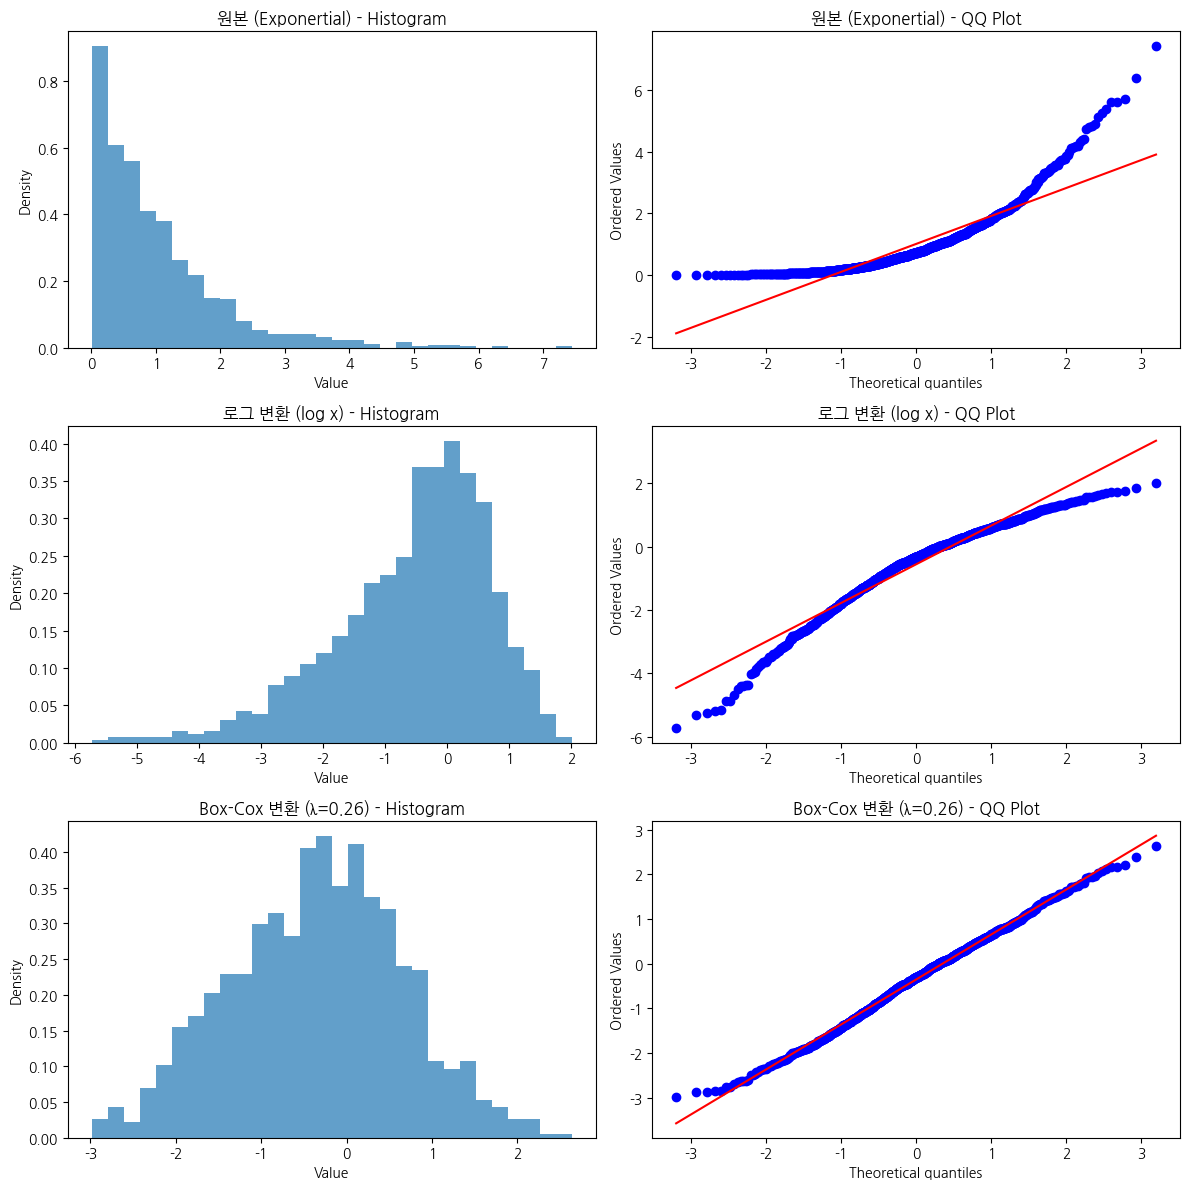

In [39]:
## --------------------------------------------------------------
## 시각화: 히스토그램 + QQ Plot
## --------------------------------------------------------------
## QQ Plot(Quantile-Quantile Plot)
## -> 데이터가 특정 분포(보통 정규분포)를 따르는지 시각적으로
##    판단하기 위한 그래프
## --------------------------------------------------------------   
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
x = skewedSR.values

data_list = [ (x, "원본 (Exponertial)"),
             (x_log, "로그 변환 (log x)"),
             (x_boxcox, f"Box-Cox 변환 (λ={lam:.2f})"),
]

for row, (data, title) in enumerate(data_list):
    ## 히스토그램
    ax_hist = axes[row, 0]
    ax_hist.hist(data, bins=30, density=True, alpha=0.7)
    ax_hist.set_title(f"{title} - Histogram")
    ax_hist.set_xlabel('Value')
    ax_hist.set_ylabel('Density')

    ## QQ Plot (정규분포와 비교)
    ax_qq = axes[row, 1]
    probplot(data, dist="norm", plot=ax_qq)
    ax_qq.set_title(f"{title} - QQ Plot")

plt.tight_layout()
plt.show()